In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors, gridspec

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

import cv2
import os

model_dir = "/home/olle/PycharmProjects/LODE/feature_segmentation/trained_model/ensemble_curated"

img_dir = os.path.join(model_dir, "test_images")
lbl_dir = os.path.join(model_dir, "test_labels")
prediction_dir = os.path.join(model_dir, "test_predictions")

In [42]:
def color_mappings():
    color_palett = np.array([[148., 158., 167.],
                             [11., 151., 199.],
                             [30., 122., 57.],
                             [135., 191., 234.],
                             [37., 111., 182.],
                             [156., 99., 84.],
                             [226., 148., 60.],
                             [203., 54., 68.],
                             [192., 194., 149.],
                             [105., 194., 185.],
                             [205., 205., 205.],
                             [140., 204., 177.],  # Serous PED
                             [183., 186., 219.],  # other artifact
                             [114, 137, 218],  # fibrosis
                             [209., 227., 239.],
                             [226., 233., 48.]])

    color_palett_norm = color_palett / 255.  # (np.max(color_palett)-np.min(color_palett))
    custom_cmap = colors.ListedColormap(
        color_palett_norm
    )

    # set counts and norm
    array_bounds = np.arange(color_palett.shape[0] + 1) - 0.5
    bounds = array_bounds.tolist()
    norm = colors.BoundaryNorm(bounds, custom_cmap.N)
    return custom_cmap, norm, bounds

def plot_image_label_prediction(records):
    # set prediction to black if not given
    if len(records) < 3:
        records.append(np.zeros(records[0].shape))

    seg_cmap, seg_norm, bounds = color_mappings()
    fig = plt.figure(figsize=(16, 4))

    gs = gridspec.GridSpec(nrows=1,
                           ncols=3,
                           width_ratios=[1, 1, 1],
                           height_ratios=[1],
                           wspace=0.3,
                           hspace=0.3,
                           figure=fig,
                           )

    # turn image to 3 channel
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(records[0])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title("oct")

    # check label shape
    if len(records[1].shape) == 3:
        records[1] = records[1][:, :, 0]

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(records[1], interpolation='nearest', cmap=seg_cmap, norm=seg_norm)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("ground truth")

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(records[2], interpolation='nearest', cmap=seg_cmap, norm=seg_norm)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title("prediction")

    plt.show()
    
def iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

def plot_bboxes(segmentation, image, feature=8, color="red", ground_truth=True):
    mask = segmentation == feature
    
    mask = mask.reshape(256,256)
    
    # label image regions
    label_image = label(mask)

    regions = regionprops(label_image)

    regions_to_remove = []
    for k, region in enumerate(regions):
        if ground_truth:
            if region.area < 10:
                regions_to_remove.append(region)

            else:
                minr, minc, maxr, maxc = region.bbox
                rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor=color, linewidth=2)
                ax.add_patch(rect)
                
        else:
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor=color, linewidth=2)
            ax.add_patch(rect)

    for region in regions_to_remove:
        regions.remove(region)
        
    return regions

# Example 1

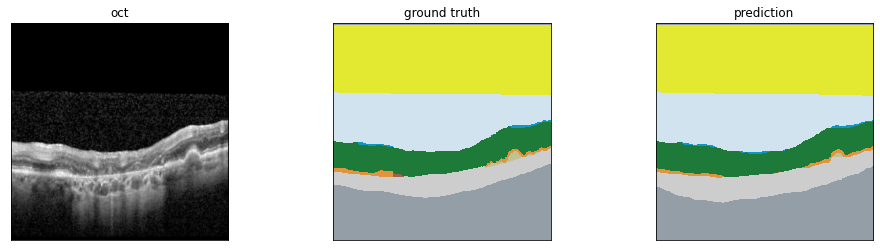

In [44]:
# load records
record_name = "295655_L_20170822_563504001_40"
im_path = os.path.join(img_dir, record_name + ".png")
lbl_path = os.path.join(lbl_dir, record_name + ".npy")
pred_path = os.path.join(prediction_dir, record_name + ".npy")

image = cv2.imread(im_path)
ground_truth = np.load(lbl_path)
prediction = np.load(pred_path)

plot_image_label_prediction([image, ground_truth, prediction])

#### Extract Blobs

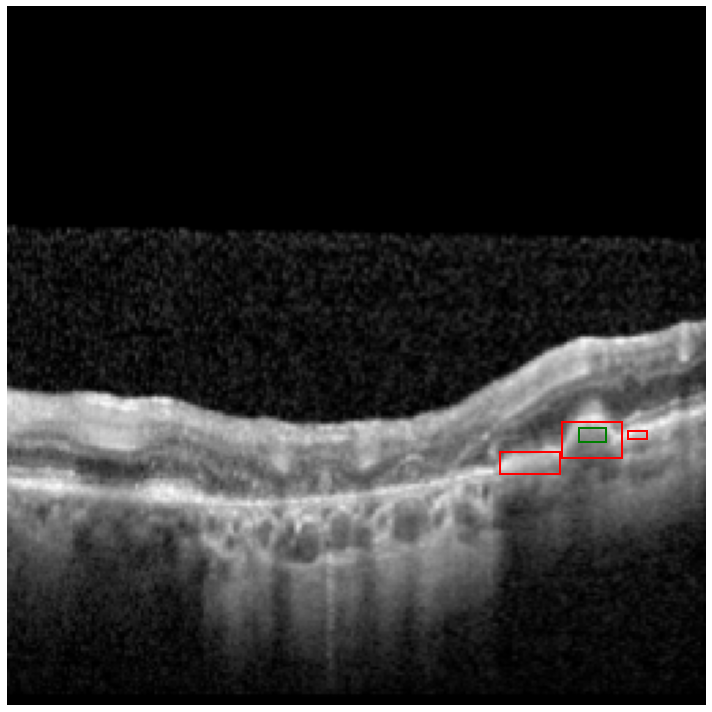

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
image = cv2.resize(image, (256,256))

ax.imshow(image)

lbl_regions = plot_bboxes(ground_truth, image, feature=8, color="red", ground_truth=True)
prediction_regions = plot_bboxes(prediction, image, feature=8, color="green", ground_truth=False)

ax.set_axis_off()
plt.tight_layout()
plt.show()